# Сравнение эффективности линейной и LSTM моделей

## Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input


## 1. Загрузка данных


In [87]:
file_path = './dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

time_features = ['hour', 'day_of_week', 'is_weekend', 'month', 'hour_sin', 'hour_cos']
target_feature = 'Global_active_power'

split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data = df[split_idx:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_np = scaler.fit_transform(train_data) 
test_scaled_np = scaler.transform(test_data)  

train_scaled = pd.DataFrame(train_scaled_np, columns=df.columns, index=train_data.index)
test_scaled = pd.DataFrame(test_scaled_np, columns=df.columns, index=test_data.index)

## 2. Линейная модель

Используются только временные признаки для предсказывания значений таргета в будущем

### 2.1. Подготовка данных

In [88]:
X_train_lr = train_scaled[time_features]
y_train_lr = train_scaled[target_feature]

X_test_lr = test_scaled[time_features]
y_test_lr = test_scaled[target_feature]

### 2.2. Обучение

In [89]:
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

LinearRegression()

### 2.3. Предсказание

In [90]:
y_pred_lr_scaled = lr_model.predict(X_test_lr)

### 2.4. Денормализация

In [91]:
def denormalize(scaler, values, column_name, df_columns):
    target_index = list(df_columns).index(column_name)
    full_shape = np.zeros((len(values), len(df_columns)))
    full_shape[:, target_index] = values.flatten()
    return scaler.inverse_transform(full_shape)[:, target_index]

real_values = df.loc[test_data.index, target_feature].values
y_pred_lr_unscaled = denormalize(scaler, y_pred_lr_scaled, target_feature, df.columns)

### 2.5. Оценка точности

In [92]:
mse_lr = mean_squared_error(real_values, y_pred_lr_unscaled)
mape_lr = mean_absolute_percentage_error(real_values, y_pred_lr_unscaled)

print(f"MSE: {mse_lr:.2f} - среднеквадратичная ошибка")
print(f"MAPE: {mape_lr * 100:.2f}% - cредняя абсолютная процентная ошибка")

MSE: 0.72 - среднеквадратичная ошибка
MAPE: 129.41% - cредняя абсолютная процентная ошибка


Ошибка получилась довольно большой, что может означать, что признаки, на которых обучалась модель не так сильно влияют на таргетное значение 

### 2.6. Визуализация

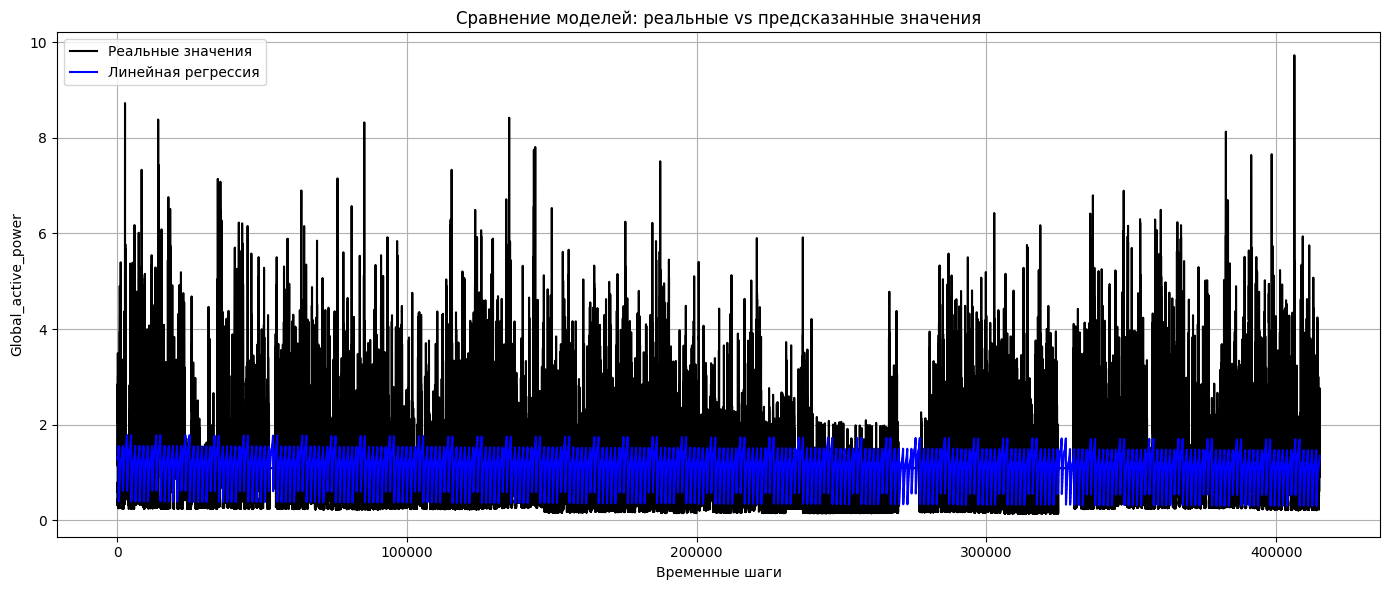

In [93]:
plt.figure(figsize=(14, 6))
plt.plot(real_values, label='Реальные значения', color='black')
plt.plot(y_pred_lr_unscaled, label='Линейная регрессия', color='blue')
plt.title('Сравнение моделей: реальные vs предсказанные значения')
plt.xlabel('Временные шаги')
plt.ylabel('Global_active_power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Можем заметить, что линейная модель не смогла описать резкие изменения целевой переменной

### 2.7. Оценка важности признаков

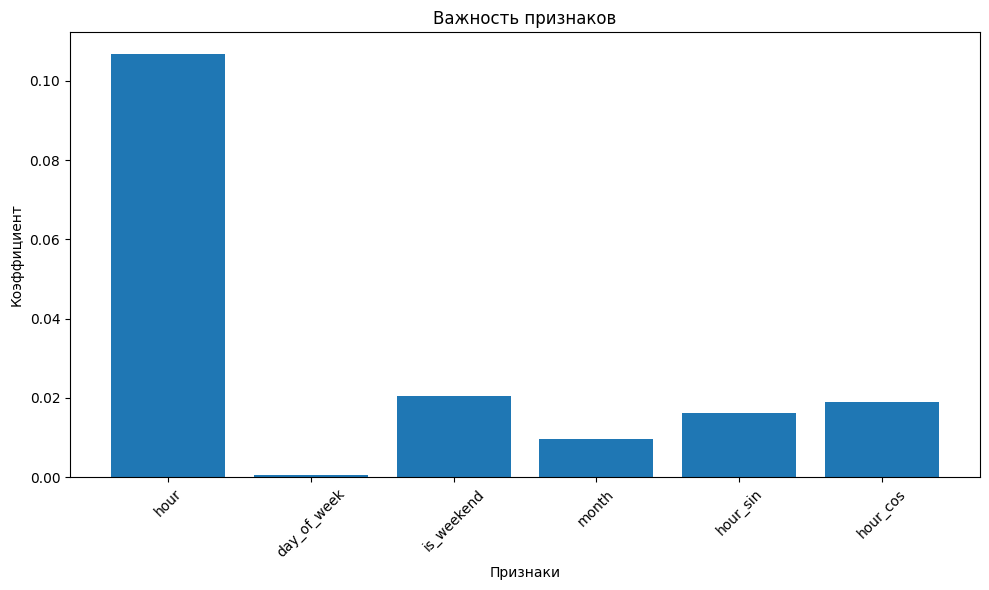

In [94]:
importance = abs(lr_model.coef_)
plt.figure(figsize=(10, 6))
plt.bar(time_features, importance)
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На этом графике мы можем заметить, что при обучении линейной модели день недели и месяц не сильно важны для предсказания потребления электроэнергии

## 3. LSTM модель

Используются все признаки, но для использования нужно будет создавать последовательности данных и корректное предсказание может происходить только на одно значения после последовательности. Например обучение происходит на 23 часах и предсказывается значение на 24 час и т.д.

### 3.1. Подготовка данных

В тренировочные и тестовые данные включается также значение таргета  

In [95]:
def create_sequence(data, target_col, window_size=24):
    X, y = [], []
    data_array = data.values
    target_idx = list(data.columns).index(target_col)
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:i+window_size])
        y.append(data_array[i+window_size, target_idx])
    return np.array(X), np.array(y)

window_size = 60

X_train_lstm, y_train_lstm = create_sequence(train_scaled, target_feature, window_size)
X_test_lstm, y_test_lstm = create_sequence(test_scaled, target_feature, window_size) 

### 3.2. Обучение 

In [ ]:
features_count = train_data.shape[1]

model = Sequential([
    Input(shape=(window_size, features_count)), 
    LSTM(50, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm)
)

Epoch 1/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 828s 16ms/step - loss: 6.8470e-04 - val_loss: 3.3907e-04
Epoch 2/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 951s 18ms/step - loss: 5.0917e-04 - val_loss: 3.3175e-04
Epoch 3/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 907s 17ms/step - loss: 4.8210e-04 - val_loss: 3.3402e-04
Epoch 4/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 946s 18ms/step - loss: 4.6333e-04 - val_loss: 3.2246e-04
Epoch 5/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 968s 19ms/step - loss: 4.4606e-04 - val_loss: 3.2366e-04
Epoch 6/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 1022s 20ms/step - loss: 4.4580e-04 - val_loss: 3.1137e-04
Epoch 7/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 1025s 20ms/step - loss: 4.3930e-04 - val_loss: 3.0622e-04
Epoch 8/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 852s 16ms/step - loss: 4.2777e-04 - val_loss: 3.0238e-04
Epoch 9/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 658s 13ms/step - loss: 4.2487e-04 - val_loss: 3.0618e-04
Epoch 10/10
51880/51880 ━━━━━━━━━━━━━━━━━━━━ 690s 13ms/step - loss: 4.2377e-04 - val_loss

In [105]:
from tensorflow.keras.models import load_model

model.save('my_lstm_model.keras')  # или .h5

# Чтобы подключить заново
# loaded_model = load_model('my_lstm_model.keras')

### 3.3 Предсказание 

In [97]:
y_pred_lstm = model.predict(X_test_lstm)

12969/12969 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step


### 3.4. Денормализация

In [98]:
y_pred_lstm_unscaled = denormalize(scaler, y_pred_lstm, target_feature, df.columns)
real_values = df.loc[test_scaled.index, target_feature].values[window_size:]  

### 3.5. Оценка точности

In [99]:
mse_lstm = mean_squared_error(real_values, y_pred_lstm_unscaled)
mape_lstm = mean_absolute_percentage_error(real_values, y_pred_lstm_unscaled)

print(f"MSE: {mse_lstm:.2f} - среднеквадратичная ошибка")
print(f"MAPE: {mape_lstm * 100:.2f}% - cредняя абсолютная процентная ошибка")

MSE: 0.04 - среднеквадратичная ошибка
MAPE: 9.58% - cредняя абсолютная процентная ошибка


### 3.5. Визуализация

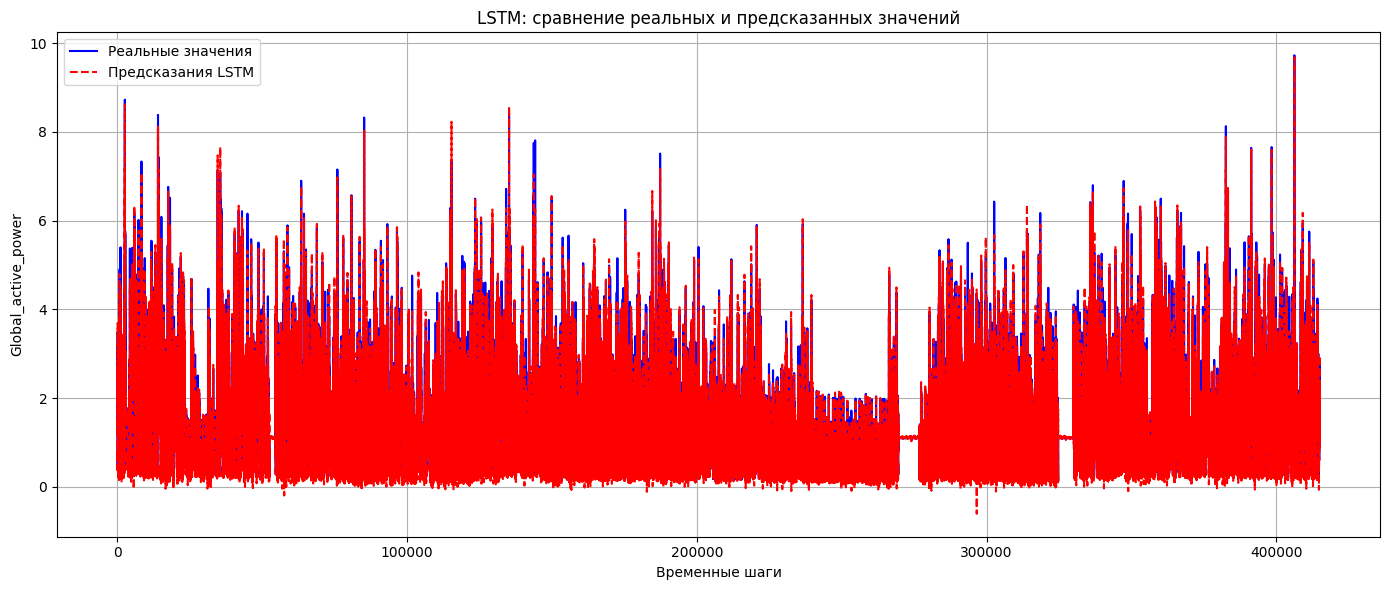

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(real_values, label='Реальные значения', color='blue')
plt.plot(y_pred_lstm_unscaled, label='Предсказания LSTM', color='red', alpha=0.7)
plt.title('LSTM: сравнение реальных и предсказанных значений')
plt.xlabel('Временные шаги')
plt.ylabel('Global_active_power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
